# import libs

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
torch.__version__

'1.1.0'

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
device

'cuda'

In [5]:
import sys
import os

In [6]:
cwd = os.getcwd()

In [7]:
sys.version_info

sys.version_info(major=3, minor=6, micro=8, releaselevel='final', serial=0)

In [8]:
import random

In [9]:
random.seed(1)
torch.manual_seed(1)
if device == 'cuda':
    torch.cuda.manual_seed_all(1)

# VAE- Encoder

In [10]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        # for encoder
        self.enc_layer1 = nn.Linear(in_features = 28*28, out_features = 512)
        self.enc_layer2 = nn.Linear(in_features = 512, out_features = 256)
        
        # encoder z_mean & z_log_sigma_sq
        self.z_mean_layer = nn.Linear(256, 2)
        self.z_log_sigma_sq_layer  = nn.Linear(256, 2)
    
    def reparam(self, z_mean, z_log_sigma_sq):
        
        eps = torch.randn(2)
        eps = eps.to(device)
        
        z = z_mean + torch.sqrt(torch.exp(z_log_sigma_sq)) * eps
        
        return eps, z
                
    def forward(self, x):
        x = F.relu(self.enc_layer1(x))
        x = F.relu(self.enc_layer2(x))
        
        z_mean = self.z_mean_layer(x)
        z_log_sigma_sq  = self.z_log_sigma_sq_layer(x)
    
        
        eps, z = self.reparam(z_mean, z_log_sigma_sq)
        return z_mean, z_log_sigma_sq, eps, z

In [11]:
encoder = Encoder().to(device)

# VAE - Decoder

In [12]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
 
        # for decoder
        self.dec_layer1 = nn.Linear(in_features = 2, out_features = 256)
        self.dec_layer2 = nn.Linear(in_features = 256, out_features = 512)
        
        # for reconstruction
        self.recons_layer = nn.Linear(512, 28*28)
        
    def forward(self, x):
        x = F.relu(self.dec_layer1(x))
        x = F.relu(self.dec_layer2(x))
        
        
        x = self.recons_layer(x)
        x = torch.sigmoid(x)
    
        return x

In [13]:
decoder = Decoder().to(device)

# Data Load

In [14]:
from lib.mnist import *

In [15]:
mymnist = MyMNIST()

# Train

In [16]:
encoder.train()

Encoder(
  (enc_layer1): Linear(in_features=784, out_features=512, bias=True)
  (enc_layer2): Linear(in_features=512, out_features=256, bias=True)
  (z_mean_layer): Linear(in_features=256, out_features=2, bias=True)
  (z_log_sigma_sq_layer): Linear(in_features=256, out_features=2, bias=True)
)

In [17]:
decoder.train()

Decoder(
  (dec_layer1): Linear(in_features=2, out_features=256, bias=True)
  (dec_layer2): Linear(in_features=256, out_features=512, bias=True)
  (recons_layer): Linear(in_features=512, out_features=784, bias=True)
)

In [18]:
params = list(encoder.parameters())+ list(decoder.parameters())

In [19]:
learning_rate = 1e-3
epochs = 10

In [20]:
optimizer = optim.Adam(params, lr=learning_rate)
recons_loss_function = nn.BCELoss(reduction ='sum')

only '1' class: normal, others: abnormal

In [21]:
for i in range(epochs):
    for X, Y in mymnist.train_data_loader:
        avg_loss = 0
        Y = Y == 1 # only 1 class is normal
        X = X.view([-1, 28*28]).to(device)
        X = X[Y]

        
        
        z_mean, z_log_sigma_sq, eps, z = encoder(X)
        X_hat = decoder(z)

        recons_loss = -recons_loss_function(X_hat, X)
        KLD = 0.5 * torch.sum(z_mean**2 + torch.exp(z_log_sigma_sq) 
                              -z_log_sigma_sq -1)

        ELBO = torch.mean(-recons_loss + KLD)

        optimizer.zero_grad()
        ELBO.backward()
        optimizer.step()
        
        avg_loss += ELBO / len(mymnist.train_data_loader)
    
    print('Epoch: {}, avg loss: {}'.format(i+1, avg_loss))
    

Epoch: 1, avg loss: 2.021543025970459
Epoch: 2, avg loss: 1.6980074644088745
Epoch: 3, avg loss: 0.8988869190216064
Epoch: 4, avg loss: 1.5473864078521729
Epoch: 5, avg loss: 1.283879041671753
Epoch: 6, avg loss: 1.8838728666305542
Epoch: 7, avg loss: 1.5336138010025024
Epoch: 8, avg loss: 1.8305293321609497
Epoch: 9, avg loss: 2.1448445320129395
Epoch: 10, avg loss: 1.0436557531356812


# Test
- Determine abnormal class based on mse

In [22]:
import matplotlib.pyplot as plt

In [23]:
display_num = 30

for X, Y in mymnist.test_data_loader:
    X = X.view([-1, 28*28]).to(device)
    break
    
z_mean, z_log_sigma_sq, eps, z = encoder(X)
X_hat = decoder(z)

In [24]:
display_num = 30
col = 28
row = 28

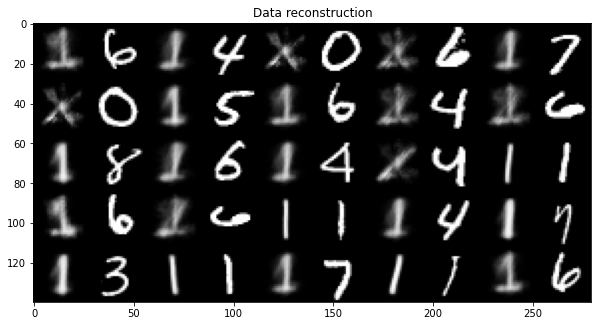

In [26]:
n = np.sqrt(display_num).astype(np.int32)
reconstructed = np.empty((col*n, 2*row*n))
for i in range(n):
    for j in range(n):
        x = np.concatenate(
            (X_hat[i*n+j, :].cpu().detach().numpy().reshape(col, row), 
             X[i*n+j, :].cpu().reshape(col, row)),
            axis=1
        )
        reconstructed[i*col:(i+1)*col, j*2*row:(j+1)*2*row] = x

plt.figure(figsize=(10, 20))
plt.title('Data reconstruction')
plt.imshow(reconstructed, cmap='gray')

## abnormal threshold settings

In [27]:
mse_normal_array = []

normal array

In [28]:
with torch.no_grad():
    encoder.eval()
    decoder.eval()
    
    for X, Y in mymnist.train_data_loader:
        Y = Y == 1
        X_normal = X.view([-1, 28*28]).to(device)
        X_normal = X_normal[Y]
        
        z_mean, z_log_sigma_sq, eps, z = encoder(X_normal)
        X_hat_normal = decoder(z)
        
        mse_normal_array.append(np.mean(np.power((X_normal.cpu().numpy() - X_hat_normal.cpu().numpy()), 2), axis=1))

In [29]:
import itertools

In [30]:
mse_normal_array = list(itertools.chain(*mse_normal_array))

In [31]:
len(mse_normal_array)

6729

In [32]:
import pandas as pd

In [33]:
df = pd.DataFrame(mse_normal_array, columns = ['mse'])

In [34]:
df['label'] = 0

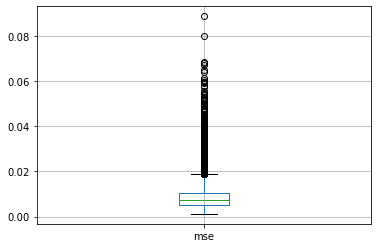

In [35]:
df[['mse']].boxplot()
plt.show()

In [36]:
df['mse'].describe()

count    6729.000000
mean        0.009051
std         0.007042
min         0.001168
25%         0.005051
50%         0.007271
75%         0.010551
max         0.088647
Name: mse, dtype: float64

abnormal mse

In [37]:
mse_abnormal_array = []

In [38]:
with torch.no_grad():
    encoder.eval()
    decoder.eval()
    
    for X, Y in mymnist.train_data_loader:
        Y = Y != 1
        X_normal = X.view([-1, 28*28]).to(device)
        X_normal = X_normal[Y]
        
        z_mean, z_log_sigma_sq, eps, z = encoder(X_normal)
        X_hat_normal = decoder(z)
        
        mse_abnormal_array.append(np.mean(np.power((X_normal.cpu().numpy() - X_hat_normal.cpu().numpy()), 2), axis=1))

In [39]:
mse_abnormal_array = list(itertools.chain(*mse_abnormal_array))

In [40]:
df_abnormal = pd.DataFrame(mse_abnormal_array, columns = ['mse'])

In [41]:
df_abnormal['label'] = 1

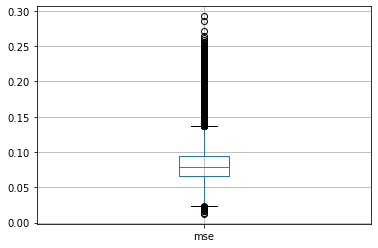

In [42]:
df_abnormal[['mse']].boxplot()
plt.show()

In [43]:
df_abnormal[['mse']].describe()

,mse
count,53170.000000
mean,0.083424
std,0.027017
min,0.012296
25%,0.066010
50%,0.078586
75%,0.094355
max,0.292266


In [44]:
df_anomaly = pd.concat([df, df_abnormal], axis = 0)

In [45]:
df_anomaly

,mse,label
0,0.013901,0
1,0.003939,0
2,0.006649,0
3,0.029790,0
4,0.005226,0
...,...,...
53165,0.135085,1
53166,0.205681,1
53167,0.102509,1
53168,0.035749,1


In [46]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix, classification_report

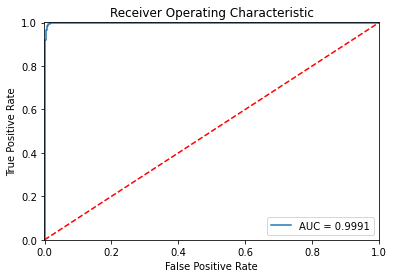

In [47]:
fpr, tpr, thresholds = roc_curve(df_anomaly["label"], df_anomaly["mse"])
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()